# **Riiid! Answer Correctness Prediction**

## Imports librairies

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

## Functions

## Data loading

We will follow this tutorials : [Competition API Detailed Introduction](https://www.kaggle.com/sohier/competition-api-detailed-introduction) and 
[Tutorial on reading large datasets](http://https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/).

In [2]:
%%time

questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')

CPU times: user 15.9 ms, sys: 5.12 ms, total: 21 ms
Wall time: 25.6 ms


In [3]:
%%time

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', 
                       low_memory=False, 
                       nrows=10**6, 
                       dtype=dtypes
                      )
print("Train size:", train_df.shape)

Train size: (1000000, 10)
CPU times: user 2.93 s, sys: 330 ms, total: 3.26 s
Wall time: 3.39 s


### 'prior_question_had_explanation' (boolean)

In [4]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df.loc[train_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
train_df.loc[train_df["prior_question_had_explanation"]== False, "prior_had_explanation_le"] = 0

In [5]:
train_df = train_df.drop(['prior_question_had_explanation'], axis=1)
train_df['prior_had_explanation_le'].astype('int8')

0         0
1         0
2         0
3         0
4         0
         ..
999995    1
999996    1
999997    1
999998    1
999999    1
Name: prior_had_explanation_le, Length: 1000000, dtype: int8

In [6]:

#train_only_questions_df['prior_question_had_explanation'].value_counts() / len(train_only_questions_df[~train_only_questions_df['prior_question_had_explanation'].isna()])

### timestamp

In [7]:
nbMillisecByYear = 1000 * 60 * 60 * 24 * 365
nbMillisecByMonth = nbMillisecByYear / 12
train_df['timestamp_by_month'] = train_df['timestamp']/nbMillisecByMonth

In [8]:
train_df = train_df[train_df['timestamp_by_month'] <= 24]

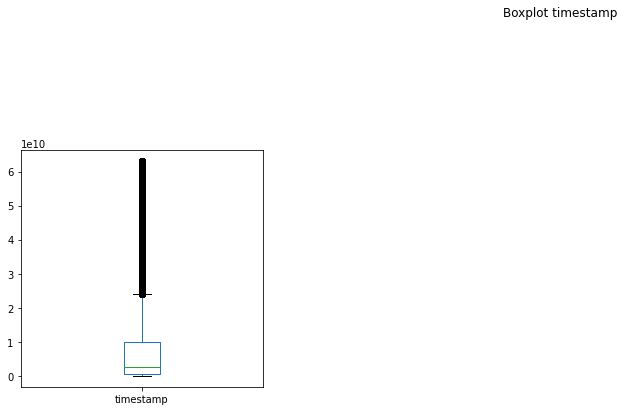

In [9]:
train_df['timestamp'].plot(kind='box', subplots=True, title='Boxplot timestamp', figsize=(20,20), layout=(4,4))
plt.show()

### prior_question_elapsed_time

In [10]:
train_df['prior_question_elapsed_time_in_min'] = train_df['prior_question_elapsed_time']/1000/60

In [11]:
prior_question_elapsed_time_mean = train_df[~train_df['prior_question_elapsed_time'].isna()]['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

### Correlation

In [12]:
train_only_questions_df = train_df[train_df['content_type_id'] == 0]
train_only_questions_df = train_only_questions_df.reindex(columns=['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_had_explanation_le',
       'timestamp_by_month', 'prior_question_elapsed_time_in_min'])
train_only_questions_df.columns


Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_had_explanation_le',
       'timestamp_by_month', 'prior_question_elapsed_time_in_min'],
      dtype='object')

In [13]:
list_columns_corr = ['timestamp', 'user_id', 'content_id', 
                     'task_container_id', 'user_answer', 'answered_correctly',
                     'prior_question_elapsed_time', 'prior_had_explanation_le']

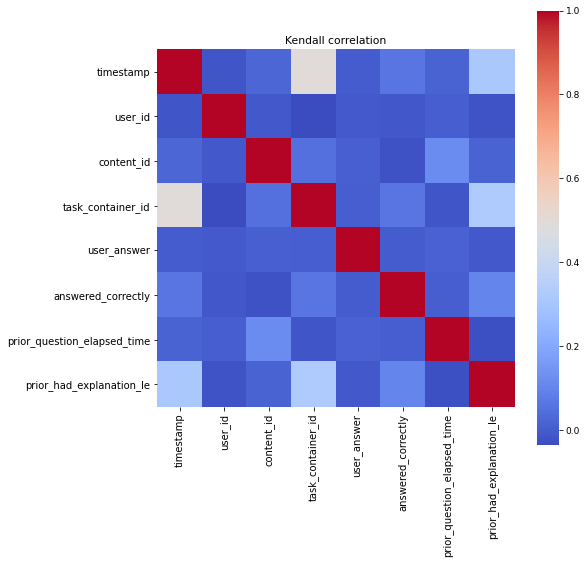

In [14]:
corr = train_only_questions_df[~(train_only_questions_df['prior_question_elapsed_time'].isna())][list_columns_corr].corr(method = "kendall")
f, ax = plt.subplots(figsize=(8, 8))
plt.rcParams['font.size'] = 9
ax.set_title('Kendall correlation')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), fmt=".2f", cmap='coolwarm', square=True, ax=ax )

## questions.csv

In [15]:
import nltk

In [16]:
questions_df['tags'].fillna("", inplace=True)
questions_df["nb_tags"] = questions_df["tags"].apply(lambda text: len(text.split()))

In [17]:
questions_df = questions_df[questions_df["nb_tags"] > 0]

In [18]:
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [19]:
questions_df['tags_list'] = questions_df['tags'].apply(lambda x: x.split())
tags_list = [item for sublist in questions_df['tags_list'].values for item in sublist]
print(len(tags_list))
tags_unique_list = list(set(tags_list))
# Affiche la nouvelle liste 
print(len(tags_unique_list))

30992
188


In [20]:
tags_frequence= nltk.FreqDist(tags_list)
words_most_common = tags_frequence.most_common(20)
fq_words_df = pd.DataFrame(words_most_common, columns = ['tags' , 'nb_tags']) 

selected_tags = (fq_words_df['tags'][:20]).to_list()

def tags_column_processing(tags):
    new_tags = []
    tags_words = tags.split()
    for tag in tags_words:
        if (tag in selected_tags) :
            new_tags.append(tag)   
    return new_tags

questions_df['new_tags'] = questions_df["tags"].apply(lambda text : tags_column_processing(text))
from sklearn.preprocessing import MultiLabelBinarizer
classes_tags = tuple(selected_tags)
one_hot = MultiLabelBinarizer(classes = classes_tags )
types_encoded = pd.DataFrame(one_hot.fit_transform(questions_df['new_tags']),columns=one_hot.classes_)
types_encoded.head()
questions_df = pd.concat([questions_df,types_encoded], axis = 1)


In [21]:
questions_df.columns

Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags', 'nb_tags',
       'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6', 'tags_list',
       'new_tags', '92', '38', '81', '29', '136', '162', '102', '8', '143',
       '131', '73', '21', '53', '82', '74', '106', '1', '96', '12', '97'],
      dtype='object')

In [22]:
questions_df = questions_df.drop(['new_tags', 'tags', 'tags_list'],axis = 1)

In [23]:
questions_df['part'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan])

In [24]:
questions_df['is_reading_section']= 0 
questions_df.loc[questions_df['part'] >= 5 ,'is_reading_section'] = 1

In [25]:
questions_df['is_easy_part'] = 0
questions_df['is_medium_part'] = 0
questions_df['is_difficult_part'] = 0
questions_df.loc[questions_df['part'] <= 3 ,'is_easy_part'] = 1
questions_df.loc[(questions_df['part'] == 4)|(questions_df['part'] == 5) ,'is_difficult_part'] = 1
questions_df.loc[questions_df['part'] >6 ,'is_medium_part'] = 1

In [26]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,nb_tags,tags1,tags2,tags3,tags4,tags5,...,74,106,1,96,12,97,is_reading_section,is_easy_part,is_medium_part,is_difficult_part
0,0.0,0.0,0.0,1.0,4.0,51.0,131.0,162.0,38.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,1.0,1.0,1.0,1.0,3.0,131.0,36.0,81.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,2.0,2.0,0.0,1.0,4.0,131.0,101.0,162.0,92.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,3.0,3.0,0.0,1.0,4.0,131.0,149.0,162.0,29.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
4,4.0,4.0,3.0,1.0,4.0,131.0,5.0,162.0,38.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0


## Merge questions and train

In [27]:
import gc
data_df = pd.merge(train_only_questions_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')

del train_only_questions_df
gc.collect()

0

In [28]:
data_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_had_explanation_le,...,74,106,1,96,12,97,is_reading_section,is_easy_part,is_medium_part,is_difficult_part
0,0,0,115,5692,0,1,3,1,25312.558594,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1,1,56943,115,5716,0,2,2,1,37000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
2,2,118363,115,128,0,0,0,1,55000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,3,131167,115,7860,0,3,0,1,19000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
4,4,137965,115,7922,0,4,1,1,11000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0


## Pivot tables

In [29]:
train_df[['user_answer', 'answered_correctly']].groupby(['user_answer'], as_index=False).mean().sort_values(by='answered_correctly', ascending=False)

,user_answer,answered_correctly
3,2,0.658296
1,0,0.652754
4,3,0.651928
2,1,0.641866
0,-1,-1.000000


In [30]:
# data_df[['part', 'answered_correctly']].groupby(['part'], as_index=False).mean().sort_values(by='answered_correctly', ascending=False)


In [31]:
# Display information by user ID 
# print(pd.pivot_table(data_df, index='user_id', values=['timestamp', 'prior_question_elapsed_time', 'answered_correctly'], aggfunc='mean'))

# Target

In [32]:

# We should exclude information about lectures.
train_df_questions = data_df
train_df_questions['answered_correctly'].mean()

0.6505707191460237

In [33]:
'''cids = train_df.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()'''

'cids = train_df.content_id.value_counts()[:30]\n\nfig = plt.figure(figsize=(12,6))\nax = cids.plot.bar()\nplt.title("Thirty most used content id\'s")\nplt.xticks(rotation=90)\nax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), \',\'))) #add thousands separator\nplt.show()'

In [34]:
data_df['is_first_question'] = 0

data_df.loc[data_df['prior_question_elapsed_time'].isna(),'is_first_question'] = 1


In [35]:
data_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_had_explanation_le,...,106,1,96,12,97,is_reading_section,is_easy_part,is_medium_part,is_difficult_part,is_first_question
0,0,0,115,5692,0,1,3,1,25312.558594,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
1,1,56943,115,5716,0,2,2,1,37000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
2,2,118363,115,128,0,0,0,1,55000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,3,131167,115,7860,0,3,0,1,19000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,4,137965,115,7922,0,4,1,1,11000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [36]:
user_agg = data_df.groupby('user_id')['answered_correctly'].\
                    agg(['sum', 'count']) #,'mean','median','std'])
#train_df['user_sum'] = train_df['user_id'].map(user_agg['sum']).astype('int32')
data_df['user_count'] = data_df['user_id'].map(user_agg['count']).astype('int32')
data_df['user_nb_mean'] = data_df['user_id'].map(user_agg['sum']/user_agg['count']).astype('int32')
#train_df['user_mean'] = train_df['user_id'].map(user_agg['mean']).astype('int32')
#train_df['user_median'] = train_df['user_id'].map(user_agg['median']).astype('int32')
#train_df['user_std'] = train_df['user_id'].map(user_agg['std']).astype('int32')

In [37]:
data_df['part'].fillna(4, inplace = True)

In [38]:
content_agg = data_df.groupby('content_id')['answered_correctly'].\
                        agg(['sum', 'count']) #'mean', 'median', 'std'
data_df['content_count'] = data_df['content_id'].map(content_agg['count']).astype('int32')
#train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
data_df['content_nb_mean'] = data_df['content_id'].map(content_agg['sum'] / content_agg['count'])

# Baseline

In [39]:
data_df.columns


Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_had_explanation_le',
       'timestamp_by_month', 'prior_question_elapsed_time_in_min',
       'question_id', 'bundle_id', 'correct_answer', 'part', 'nb_tags',
       'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6', '92', '38', '81',
       '29', '136', '162', '102', '8', '143', '131', '73', '21', '53', '82',
       '74', '106', '1', '96', '12', '97', 'is_reading_section',
       'is_easy_part', 'is_medium_part', 'is_difficult_part',
       'is_first_question', 'user_count', 'user_nb_mean', 'content_count',
       'content_nb_mean'],
      dtype='object')

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [41]:


features_bsl = ['timestamp_by_month', 'tags1', 'tags2', 'tags3', 
                '92', '38', '81', '29', '136', '162', '102', '8', '143', '131',
                'is_first_question', 'part',
                'prior_had_explanation_le', 
                'prior_question_elapsed_time_in_min',
                'content_id', 'content_count', 'content_nb_mean',
                'user_nb_mean', 'user_count',
                'is_easy_part', 'is_medium_part', 'is_difficult_part'
                ]


X = data_df[features_bsl]
X = sc.fit_transform(X)
y = data_df['answered_correctly']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [42]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [43]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [44]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [45]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=7, random_state=1, metric='None', n_jobs=4, n_estimators=200)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=1,
    verbose=True)

In [46]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.7514851143810443 with params: {'colsample_bytree': 0.9080972808940212, 'min_child_samples': 343, 'min_child_weight': 0.01, 'num_leaves': 42, 'reg_alpha': 5, 'reg_lambda': 0, 'subsample': 0.863184719640143} 

In [47]:
y.describe()

count    977451.000000
mean          0.650571
std           0.476790
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: answered_correctly, dtype: float64

In [48]:
clf = lgb.LGBMClassifier(max_depth=7, 
                         random_state=1, metric='None', 
                         n_jobs=4, n_estimators=200)


params = {
    #'bagging_fraction': 0.5817242323514327,
    'feature_fraction': 0.6884588361650144,
    #'learning_rate': 0.42887924851375825, 
    'learning_rate': 0.4, 
    'max_depth': 7,
    'min_child_samples': 100, 
    'min_child_weight': 0.01,
    'min_data_in_leaf': 20, 
    'n_estimators': 200,
    'n_job': 4,
    'num_leaves': 42,
    'random_state': 1,
    'reg_alpha': 5, 
    'reg_lambda': 0,
    'subsample': 0.863184719640143
}

lgbm = LGBMClassifier( **params)

In [49]:
lgbm.fit(data_df[features_bsl], y)

LGBMClassifier(feature_fraction=0.6884588361650144, learning_rate=0.4,
               max_depth=7, min_child_samples=100, min_child_weight=0.01,
               min_data_in_leaf=20, n_estimators=200, n_job=4, num_leaves=42,
               random_state=1, reg_alpha=5, reg_lambda=0,
               subsample=0.863184719640143)

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y.values, lgbm.predict_proba(data_df[features_bsl])[:,1])

0.7703414201839481

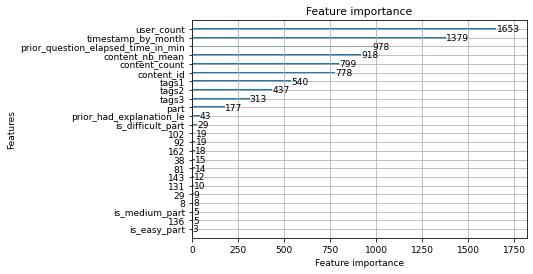

In [51]:
#displaying the most important features
lgb.plot_importance(lgbm)
plt.show()

In [52]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [53]:
import riiideducation
import pandas as pd

env = riiideducation.make_env()

In [54]:
from collections import defaultdict
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [55]:
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df[test_df['content_type_id'] == 0]
    test_df['is_first_question'] = 0
    
    test_df.loc[test_df['prior_question_had_explanation'].isna(),'is_first_question'] = 1
    
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.loc[test_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
    test_df.loc[test_df["prior_question_had_explanation"]== False, "prior_had_explanation_le"] = 0
    
    prior_question_elapsed_time_mean = test_df[~test_df['prior_question_elapsed_time'].isna()]['prior_question_elapsed_time'].mean()
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    
    
    test_df = pd.merge(test_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')
    test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_count'] = user_count
    test_df['user_sum'] = user_sum
    test_df.loc[test_df["user_count"]==0, "user_count"] = 1#test_df[test_df["user_count"]==0]["user_sum"]
    
    test_df['user_nb_mean'] = user_sum /user_count
    
    test_df['part'] = test_df.part - 1
    test_df['part'].fillna(4, inplace = True)
    
    # New user ? Pas encore de réponses ?
    test_df['content_count'] = content_count
    test_df.loc[test_df["content_count"]==0, "content_count"] = 1
    test_df['content_nb_mean'] = content_sum/content_count
    
    test_df['prior_question_elapsed_time_in_min'] = test_df['prior_question_elapsed_time']/1000/60/60
    test_df['timestamp_by_month'] = test_df['timestamp']/nbMillisecByMonth
    X = test_df[features_bsl]
    #X = sc.fit_transform(X)
    
    test_df['answered_correctly'] =  lgbm.predict(X)
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
